# Regularization methods 

In [1]:
# Import các thư viện cần thiết
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Data Preparation

In [2]:
# Đọc file 'DWD.csv' bằng thư viện pandas
dwd = pd.read_csv("DWD.csv")

In [6]:
# In các cột trong dataframe
dwd.columns

Index(['ID', 'DWD_ID', 'STATION_NAME', 'FEDERAL_STATE', 'LAT', 'LON',
       'ALTITUDE', 'PERIOD', 'RECORD_LENGTH', 'MEAN_ANNUAL_AIR_TEMP',
       'MEAN_MONTHLY_MAX_TEMP', 'MEAN_MONTHLY_MIN_TEMP',
       'MEAN_ANNUAL_WIND_SPEED', 'MEAN_CLOUD_COVER', 'MEAN_ANNUAL_SUNSHINE',
       'MEAN_ANNUAL_RAINFALL', 'MAX_MONTHLY_WIND_SPEED', 'MAX_AIR_TEMP',
       'MAX_WIND_SPEED', 'MAX_RAINFALL', 'MIN_AIR_TEMP',
       'MEAN_RANGE_AIR_TEMP'],
      dtype='object')

In [4]:
# In thông tin của dataframe (bằng 'info()')
dwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      599 non-null    int64  
 1   DWD_ID                  599 non-null    int64  
 2   STATION_NAME            599 non-null    object 
 3   FEDERAL_STATE           599 non-null    object 
 4   LAT                     599 non-null    float64
 5   LON                     599 non-null    float64
 6   ALTITUDE                599 non-null    float64
 7   PERIOD                  599 non-null    object 
 8   RECORD_LENGTH           599 non-null    int64  
 9   MEAN_ANNUAL_AIR_TEMP    598 non-null    float64
 10  MEAN_MONTHLY_MAX_TEMP   597 non-null    float64
 11  MEAN_MONTHLY_MIN_TEMP   595 non-null    float64
 12  MEAN_ANNUAL_WIND_SPEED  588 non-null    float64
 13  MEAN_CLOUD_COVER        588 non-null    float64
 14  MEAN_ANNUAL_SUNSHINE    406 non-null    fl

In [10]:
# Để biết cột nào không ảnh hưởng đến dự đoán lượng mưa trung bình hằng năm, ta tính ma trận tương quan giữa các feature:

# Lọc ra các cột không phải là 'MEAN_ANNUAL_RAINFALL'
non_target_columns = dwd.columns[dwd.columns != 'MEAN_ANNUAL_RAINFALL']

# Chuyển kiểu dữ liệu string sang int (cho các cột station_name, federal_state)
dwd[non_target_columns] = dwd[non_target_columns].apply(pd.to_numeric, errors='coerce')

# Xóa các dòng có giá trị thiếu trong cột 'MEAN_ANNUAL_RAINFALL' để tránh bị lỗi khi tính toán
dwd = dwd.dropna(subset=['MEAN_ANNUAL_RAINFALL'])

# Tính toán ma trận tương quan
correlation_matrix = dwd[non_target_columns].corrwith(dwd['MEAN_ANNUAL_RAINFALL'])

# In ra ma trận tương quan để xem mức độ tương quan của từng cột với 'MEAN_ANNUAL_RAINFALL'
print(correlation_matrix)

ID                        0.075860
DWD_ID                    0.072759
STATION_NAME                   NaN
FEDERAL_STATE                  NaN
LAT                      -0.439290
LON                      -0.152795
ALTITUDE                  0.709002
PERIOD                         NaN
RECORD_LENGTH            -0.065195
MEAN_ANNUAL_AIR_TEMP     -0.539133
MEAN_MONTHLY_MAX_TEMP    -0.439943
MEAN_MONTHLY_MIN_TEMP    -0.445130
MEAN_ANNUAL_WIND_SPEED    0.011600
MEAN_CLOUD_COVER          0.081362
MEAN_ANNUAL_SUNSHINE      0.026481
MAX_MONTHLY_WIND_SPEED    0.017099
MAX_AIR_TEMP             -0.509815
MAX_WIND_SPEED            0.292522
MAX_RAINFALL              0.863788
MIN_AIR_TEMP             -0.186723
MEAN_RANGE_AIR_TEMP      -0.122783
dtype: float64


In [13]:
# Loại bỏ các cột không cần thiết trong việc dự đoán lượng mưa trung bình hằng năm
# Các cột không ảnh hưởng đến dự đoán lượng mưa trung bình hằng năm là: ID, DWD_ID, STATION_NAME, FEDERAL_STATE, PERIOD, RECORD_LENGTH)
df = dwd.drop(['ID','DWD_ID','STATION_NAME','FEDERAL_STATE','PERIOD','RECORD_LENGTH'], axis=1).dropna()

# Hiển thị các giá trị đầu
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 1 to 596
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LAT                     204 non-null    float64
 1   LON                     204 non-null    float64
 2   ALTITUDE                204 non-null    float64
 3   MEAN_ANNUAL_AIR_TEMP    204 non-null    float64
 4   MEAN_MONTHLY_MAX_TEMP   204 non-null    float64
 5   MEAN_MONTHLY_MIN_TEMP   204 non-null    float64
 6   MEAN_ANNUAL_WIND_SPEED  204 non-null    float64
 7   MEAN_CLOUD_COVER        204 non-null    float64
 8   MEAN_ANNUAL_SUNSHINE    204 non-null    float64
 9   MEAN_ANNUAL_RAINFALL    204 non-null    float64
 10  MAX_MONTHLY_WIND_SPEED  204 non-null    float64
 11  MAX_AIR_TEMP            204 non-null    float64
 12  MAX_WIND_SPEED          204 non-null    float64
 13  MAX_RAINFALL            204 non-null    float64
 14  MIN_AIR_TEMP            204 non-null    float64

In [18]:
# Tạo ra một DataFrame mới X bằng cách loại bỏ cột 'MEAN_ANNUAL_RAINFALL' từ DataFrame gốc df
X = df.drop(columns=['MEAN_ANNUAL_RAINFALL'])
# Tạo ra một Series mới y bằng cách chọn cột 'MEAN_ANNUAL_RAINFALL' là biến mục tiêu cần dự đoán.
y = df['MEAN_ANNUAL_RAINFALL']
# Khởi tạo đối tượng scaler từ lớp StandardScaler() trong thư viện sklearn.preprocessing. 
scaler =  StandardScaler()
# Chia dữ liệu thành hai tập: Tập huấn luyện (X_train, y_train) và Tập kiểm tra (X_test, y_test). 
# Đặt random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Chuẩn hóa dữ liệu huấn luyện bằng cách sử dụng phương pháp fit_transform() từ đối tượng scaler đã được khởi tạo trước đó
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Đọc dữ liệu từ file feather 'rmses.feather'. 
# Chỉ số của DataFrame được thiết lập là cột 'index'.
rmses = pd.read_feather('rmses.feather').set_index('index')
rmses

,name,train_RMSE,test_RMSE
index,,,
0,baseline model,243.882152,180.877011
0,simple alt model,154.992815,138.854544
0,max rainfall model,119.953630,117.437897
0,multi alt rain model,118.095746,113.746363
4,forward model,87.392377,117.884639
5,backward model,87.236023,118.367974
6,mlxtend SFS model,91.976905,91.232370


## Ridge regression 

Tính toán hệ số cho $\alpha \in \left[10^{-1}, 10^5\right]$ bằng phương pháp ridge regression và vẽ biểu đồ kết quả.

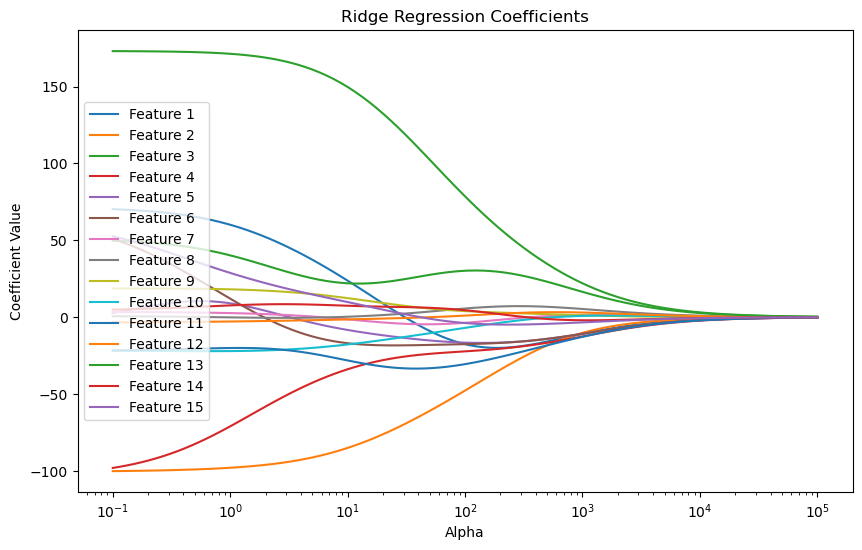

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Khởi tạo giá trị alpha từ 10^-1 đến 10^5
alphas = np.logspace(-1, 5, num=100)

# Khởi tạo các mảng để lưu trữ hệ số của các biến
coefs = []

# Chuẩn hóa dữ liệu huấn luyện
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Huấn luyện mô hình Ridge Regression với các giá trị alpha khác nhau và lưu trữ hệ số tương ứng
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)

# Vẽ biểu đồ kết quả
plt.figure(figsize=(10, 6))

for i in range(X_train.shape[1]):
    plt.plot(alphas, [coef[i] for coef in coefs], label=f'Feature {i+1}')

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients')
plt.legend()
plt.show()


Xem xét sự khác biệt của hệ số đối với các hồi quy tuyến tính đơn giản cho từng tham số. Để đạt được mục đích này, chúng ta sẽ tính toán các hệ số hồi quy tuyến tính đơn giản `reg_coeff` và tính sai số bình phương trung bình và vẽ đồ thị.

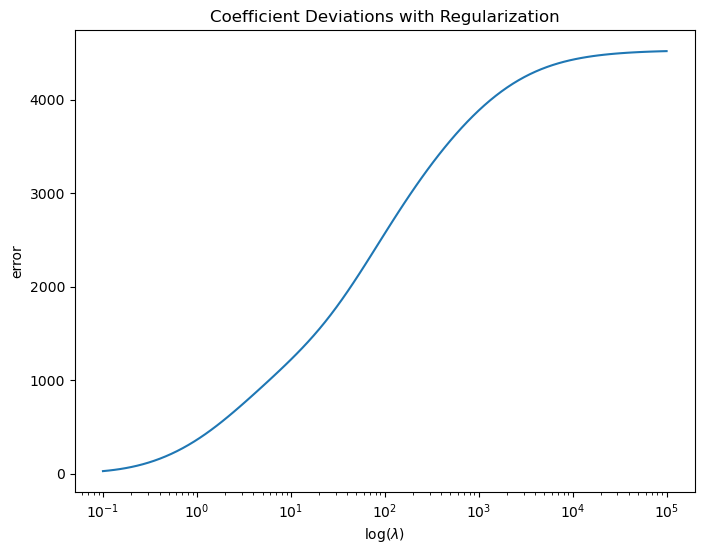

In [23]:
# Huấn luyện mô hình hồi quy tuyến tính
reg_coeff = linear_model.LinearRegression().fit(X_train, y_train)
# Tính sai số giữa hệ số của mô hình Ridge và hồi quy tuyến tính
errors = [mean_squared_error(linear_model.Ridge(alpha=a).fit(X_train, y_train).coef_, reg_coeff.coef_) for a in alphas]
# Vẽ biểu đồ để so sánh sự khác biệt của hệ số dựa trên giá trị của alpha
plt.figure(figsize=(8, 6))
plt.plot(alphas, errors)
plt.xscale('log')
plt.xlabel("log($\lambda$)")
plt.ylabel("error")
plt.title("Coefficient Deviations with Regularization")
plt.show()

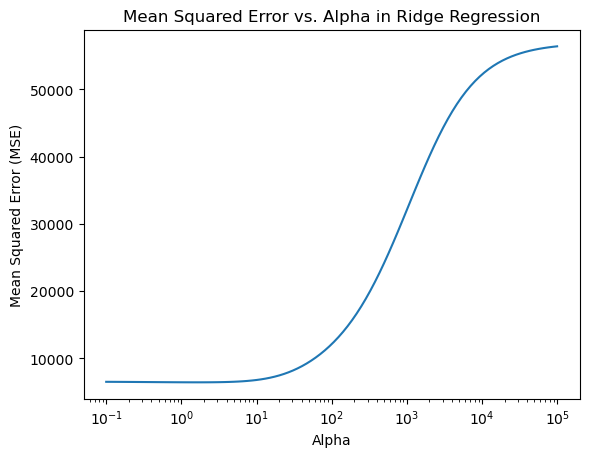

In [24]:
# Sử dụng RidgeCV từ thư viện linear_model để thực hiện ridge regression 
# với các giá trị alpha đã được xác định trước trong mảng alphas. 
# Đặt store_cv_values=True để lưu trữ giá trị cross-validated mean squared error (MSE).
reg = linear_model.RidgeCV(alphas=alphas, store_cv_values=True)
# Sử dụng phương thức fit() để đào tạo mô hình ridge trên dữ liệu huấn luyện X_train và y_train.
reg.fit(X_train, y_train)
# Lấy trục hiện tại bằng plt.gca()
ax = plt.gca()
# Vẽ biểu đồ của giá trị MSE trung bình theo 𝛼 từ các giá trị cross-validated MSE đã lưu trữ trong reg.cv_values_. 
ax.plot(reg.alphas, reg.cv_values_.mean(axis=0))
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error vs. Alpha in Ridge Regression')
plt.show()

In [25]:
# In ra màn hình các thông tin sau: Best score, Estimated regularization parameter alpha, Training score, Test score
print("Best score:", reg.best_score_)
print("Estimated regularization parameter alpha:", reg.alpha_)
print("Training score:", reg.score(X_train, y_train))
print("Test score:", reg.score(X_test, y_test))

Best score: -6440.0361349914965
Estimated regularization parameter alpha: 1.6297508346206444
Training score: 0.9081942915442122
Test score: 0.8625788494568934


In [27]:
# Dự đoán cho tập huấn luyện
y_train_pred = reg.predict(X_train)
# Tính RMSE trên tập huấn luyện
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE on training set: {rmse_train}")

RMSE on training set: 71.84011342174607


In [29]:
# Dự đoán cho tập kiểm tra
y_pred_test = reg.predict(X_test)
# Tính RMSE trên tập kiểm tra
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE on test set: {rmse_test}")

RMSE on test set: 77.40882425615033


In [35]:
# Thêm một hàng mới vào DataFrame rmses với các giá trị 'Ridge regression', rmse_train và rmse_test tương ứng.
rmses.loc[len(rmses)] = ['Ridge regresion', rmse_train, rmse_test]
rmses

,name,train_RMSE,test_RMSE
index,,,
0,baseline model,243.882152,180.877011
0,simple alt model,154.992815,138.854544
0,max rainfall model,119.953630,117.437897
0,multi alt rain model,118.095746,113.746363
4,forward model,87.392377,117.884639
5,backward model,87.236023,118.367974
6,mlxtend SFS model,91.976905,91.232370
7,Ridge regresion,71.840113,77.408824


## Final result

In [37]:
print(rmses.columns)


Index(['name', 'train_RMSE', 'test_RMSE'], dtype='object')


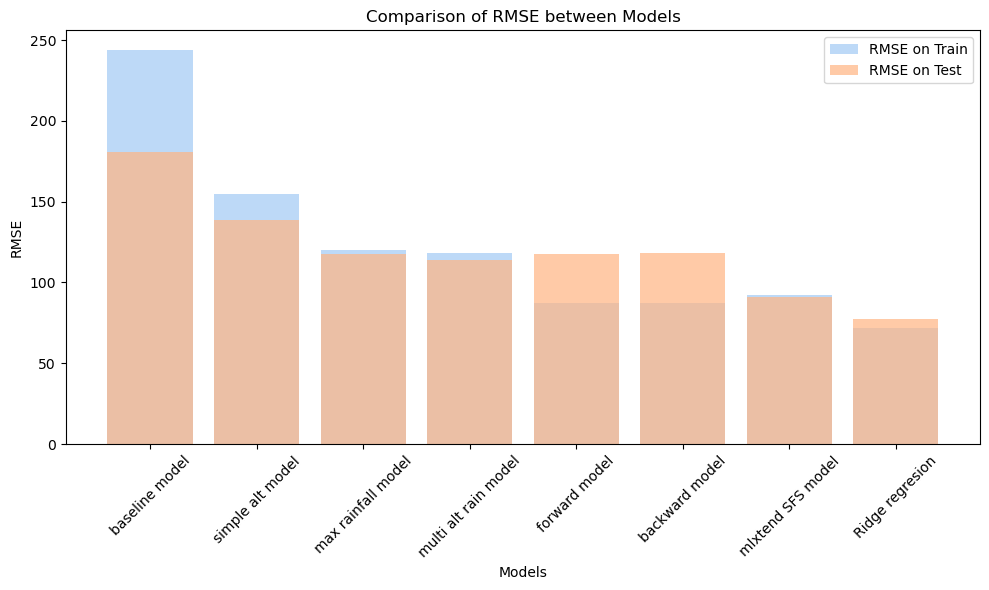

In [41]:
# Vẽ biểu đồ so sánh RMSE giữa các models huấn luyện 
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))

plt.bar(rmses['name'], rmses['train_RMSE'], alpha=0.7, label='RMSE on Train')
plt.bar(rmses['name'], rmses['test_RMSE'], alpha=0.7, label='RMSE on Test')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE between Models')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()